# Spectral Partitioning of Bipartite Graphs

Typical example of bipartite graph is a graph obtained from a collection of documents presented as a _term $\times$ document_  matrix.

## Prerequisites

The reader should be familiar with k-means algorithm and spectral graph partitioning theory and algorithms.
 
## Competences 

The reader should be able to apply spectral partitioning of bipartite graphs to data clustering problems.

__Credits.__ The notebook is based on [I. Mirošević, Spectral Graph Partitioning and Application to Knowledge Extraction][Mir05].

[Mir05]: http://empty.link "I. Mirošević, 'Spectral Graph Partitioning and Application to Knowledge Extraction', M.Sc. Thesis, Iniversity of Zagreb, 2005 (in Croatian)." 

## Definitions

_Undirected bipartite graph_ $G$ is a triplet 
$G=(T,D,E)$, where $T=\{t_{1},\cdots ,t_{m}\}$ and 
$D=\{d_{1},...,d_{n}\}$ are two sets of vertices and
$E=\{(t_{i},d_{j}):t_{i}\in R,d_{j}\in D\}$, 
is a set of edges.

$G$ is _weighted_ if there is weight $\omega(e)$ associated with each edge $e\in E$.

For example, $D$ is a set of documents, 
$T$ is a set of terms (words) and  edge $e=(t_{i},d_{j})$ exists if
document $d_{j}$ contains term $t_{i}$. Weight $\omega(e)$ can be number of appearances 
of the term $t_i$ in the document $d_j$.

A _term-by-document-matrix_ is a matrix $A\in\mathbb{R}^{m\times n}$ with 
$A_{ij}=\omega((t_i,d_j))$.

## Facts

1. The weight matrix of $G$ is 
$W=\begin{bmatrix}0 & A \\ A^{T} & 0 \end{bmatrix}$.

2. The Laplacian matrix of $G$ is 
$$L=\begin{bmatrix} \Delta_{1} & -A \\ -A^{T} & \Delta_{2}\end{bmatrix},$$
where $\Delta_1$ and $\Delta_2$ are diagonal matrices with elements 
$\Delta_{1,ii}=\sum\limits_{j=1}^n A_{ij}$ for $i=1,\ldots,m$, and 
$\Delta_{1,jj}=\sum\limits_{i=1}^m A_{ij}$ for $j=1,\ldots,n$.

3. The normalized Laplacian matrix of $G$ is 
$$L_n=\begin{bmatrix}
I & -\Delta_{1}^{-\frac{1}{2}}A\Delta_{2}^{-\frac{1}{2}} \\
-\Delta_{2}^{-\frac{1}{2}}A^T\Delta_{1}^{-\frac{1}{2}} & I
\end{bmatrix} \equiv 
\begin{bmatrix} I & -A_n \\ -A_n^T & I \end{bmatrix}.
$$

4. Let $\lambda$ be an eigenvalue of $L_n$ with an eigenvector 
$w=\begin{bmatrix} u \\ v\end{bmatrix}$, where 
$u\in \mathbb{R}^{m}$ $v\in\mathbb{R}^{n}$.
Then $L_n w=\lambda w$ implies
$A_n v =(1-\lambda)u$ and $A_n^T u=(1-\lambda)v$. Vice versa, if $(u,\sigma,v)$ is a singular triplet of $A_n$, then $1-\sigma$ is an eigenvalue of $L_n$ with (non-unit) eigenvector $w=\begin{bmatrix} u \\ v\end{bmatrix}$. 

5. The second largest singular value of $A_n$ corresponds to the second smallest eigenvalue of $L_n$, and computing the former is numerically more stable. 

5. __Bipartitioning algorithm__ is the following:
    1. For given $A$ compute $A_{n}$.
    2. Compute singular vectors of $A_{n}$, $u^{[2]}$ and $v^{[2]}$, which correspond to 
    the second largest singular value, $\sigma_2(A_n)$.
    3. Assign the partitions $T=\{T_1,T_2\}$ and $D=\{D_1,D_2\}$ according to the signs of 
    $u^{[2]}$ and $v^{[2]}$. The pair $(T,D)$ is now partitioned as 
    $\{(T_1,D_1),(T_2,D_2)\}$.


6. __Recursive bipartitioning algorithm__ is the following:
    1. Compute the bipartition $\pi=\{(T_1,D_1),(T_2,D_2)\}$ of 
    $(T,D)$. Set the counter $c=2$.
    2. While $c<k$ repeat
         1. compute bipartitions of each of the subpartitions of $(T,D)$,
         2. among all $(c+1)$-subpartitions, choose the one with the smallest 
         $pcut(\pi_{c+1})$ or $ncut(\pi_{c+1})$, respectively.
    3. Set $c=c+1$
    3. Stop

7. __Multipartitioning algorithm__ is the following:
    1. For given $A$ compute $A_{n}$.
    2. Compute $k$ left and right singular vectors, $u^{[1]},\ldots,u^{[k]}$ and 
    $v^{[1]},\ldots,v^{[k]}$, which correspond to $k$ largest singular values 
    $\sigma_1\geq \cdots \geq \sigma_k$ of $A_n$.
    3. Partition the rows of matrices 
    $\Delta_{1}^{-\frac{1}{2}}\begin{bmatrix} u^{[1]} & \ldots & u^{[k]}\end{bmatrix}$
    and 
    $\Delta_{2}^{-\frac{1}{2}}\begin{bmatrix} v^{[1]} & \ldots & v^{[k]}\end{bmatrix}$
    with the k-means algorithm.

### Example - Small term-by- document matrix

In [1]:
# Packages
using LightGraphs
using GraphPlot
using Clustering
using SparseArrays
using LinearAlgebra

In [2]:
using Plots

In [3]:
import Plots.spy
spy(A)=heatmap(A,yflip=true,color=:RdBu,aspectratio=1,clim=(-1,1.0)) 

spy (generic function with 2 methods)

In [4]:
?spy

search: spy spy! display displaysize displayable redisplay popdisplay isempty



No documentation found.

`Plots.spy` is a `Function`.

```
# 2 methods for generic function "spy":
[1] spy(A) in Main at In[3]:2
[2] spy(args...; kw...) in Plots at /home/jrun/.julia/packages/RecipesBase/Uz5AO/src/RecipesBase.jl:350
```


In [5]:
# Functions

function my_weight_matrix(src::Array,dst::Array,weights::Array)
    n=nv(G)
    sparse([src;dst],[dst;src],[weights;weights],n,n)
end

my_laplacian(W::AbstractMatrix)=spdiagm(0=>vec(sum(W,dims=2)))-W

function my_normalized_laplacian(L::AbstractMatrix)
    D=1.0./sqrt.(diag(L))
    n=length(D)
    [L[i,j]*(D[i]*D[j]) for i=1:n, j=1:n]
end

my_normalized_laplacian (generic function with 1 method)

In [6]:
# Sources, targets, and weights
n=7
dn=[6,6,7,6,7,7]
tn=[1,2,2,3,4,5]
wn=[3,1,3,2,2,3]
[dn tn wn]

6×3 Array{Int64,2}:
 6  1  3
 6  2  1
 7  2  3
 6  3  2
 7  4  2
 7  5  3

In [7]:
mynames=["Term 1";"Term 2";"Term 3";"Term 4";"Term 5";"Doc 1";"Doc 2"]

7-element Array{String,1}:
 "Term 1"
 "Term 2"
 "Term 3"
 "Term 4"
 "Term 5"
 "Doc 1" 
 "Doc 2" 

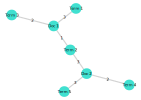

In [8]:
G=Graph(n)
for i=1:length(dn)
    add_edge!(G,tn[i],dn[i])
end
gplot(G, nodelabel=mynames, edgelabel=wn)

In [9]:
W=my_weight_matrix(tn,dn,wn)

7×7 SparseMatrixCSC{Int64,Int64} with 12 stored entries:
  [6, 1]  =  3
  [6, 2]  =  1
  [7, 2]  =  3
  [6, 3]  =  2
  [7, 4]  =  2
  [7, 5]  =  3
  [1, 6]  =  3
  [2, 6]  =  1
  [3, 6]  =  2
  [2, 7]  =  3
  [4, 7]  =  2
  [5, 7]  =  3

In [10]:
Matrix(W)

7×7 Array{Int64,2}:
 0  0  0  0  0  3  0
 0  0  0  0  0  1  3
 0  0  0  0  0  2  0
 0  0  0  0  0  0  2
 0  0  0  0  0  0  3
 3  1  2  0  0  0  0
 0  3  0  2  3  0  0

In [12]:
L=my_laplacian(W)
Matrix(L)

7×7 Array{Int64,2}:
  3   0   0   0   0  -3   0
  0   4   0   0   0  -1  -3
  0   0   2   0   0  -2   0
  0   0   0   2   0   0  -2
  0   0   0   0   3   0  -3
 -3  -1  -2   0   0   6   0
  0  -3   0  -2  -3   0   8

In [13]:
Lₙ=my_normalized_laplacian(L)

7×7 Array{Float64,2}:
  1.0        0.0        0.0       0.0   0.0       -0.707107   0.0     
  0.0        1.0        0.0       0.0   0.0       -0.204124  -0.53033 
  0.0        0.0        1.0       0.0   0.0       -0.57735    0.0     
  0.0        0.0        0.0       1.0   0.0        0.0       -0.5     
  0.0        0.0        0.0       0.0   1.0        0.0       -0.612372
 -0.707107  -0.204124  -0.57735   0.0   0.0        1.0        0.0     
  0.0       -0.53033    0.0      -0.5  -0.612372   0.0        1.0     

In [14]:
A=W[1:5,6:7]
Δ₁=sqrt.(sum(A,dims=2))
Δ₂=sqrt.(sum(A,dims=1))
Aₙ=[A[i,j]/(Δ₁[i]*Δ₂[j]) for i=1:size(A,1), j=1:size(A,2)]

5×2 Array{Float64,2}:
 0.707107  0.0     
 0.204124  0.53033 
 0.57735   0.0     
 0.0       0.5     
 0.0       0.612372

In [15]:
# The partitioning - explain the results!
U,σ,V=svd(Aₙ)

SVD{Float64,Float64,Array{Float64,2}}([-0.46291 0.604743; -0.534522 -0.218218; … ; -0.377964 -0.370328; -0.46291 -0.453557], [1.0, 0.883883], [-0.654654 -0.755929; 0.755929 -0.654654])

In [16]:
U[:,2]

5-element Array{Float64,1}:
  0.6047431568147631 
 -0.21821789023599317
  0.4937707198786937 
 -0.37032803990902124
 -0.45355736761107346

In [17]:
V[:,2]

2-element Array{Float64,1}:
  0.7559289460184536
 -0.6546536707079783

### Example - Sets of points

In [18]:
# Define sizes
using Random
m=[200,100,100]
n=[100,200,100]
density=[0.5,0.7,0.4]
A=Array{Any}(undef,3)
Random.seed!(421)
for i=1:3
    # Generate sparse random
    A[i]=sprand(m[i],n[i],density[i])
end
B=blockdiag(A[1],A[2],A[3])

400×400 SparseMatrixCSC{Float64,Int64} with 28015 stored entries:
  [4  ,   1]  =  0.934799
  [6  ,   1]  =  0.944809
  [9  ,   1]  =  0.434606
  [13 ,   1]  =  0.649754
  [20 ,   1]  =  0.779423
  [23 ,   1]  =  0.454876
  [25 ,   1]  =  0.512495
  [27 ,   1]  =  0.835728
  [29 ,   1]  =  0.115423
  [31 ,   1]  =  0.00835897
  [32 ,   1]  =  0.171255
  [35 ,   1]  =  0.503929
  ⋮
  [375, 400]  =  0.538811
  [382, 400]  =  0.0873131
  [385, 400]  =  0.261836
  [387, 400]  =  0.861092
  [388, 400]  =  0.239855
  [390, 400]  =  0.0887338
  [392, 400]  =  0.415926
  [393, 400]  =  0.779473
  [394, 400]  =  0.621798
  [395, 400]  =  0.262382
  [398, 400]  =  0.923563
  [399, 400]  =  0.276277

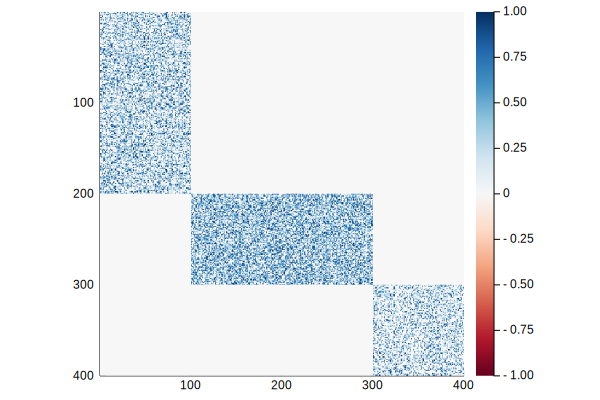

In [19]:
spy(Matrix(B))

In [20]:
# The structure of singular vectors reflects the blocks
using Arpack
S,rest=svds(B,nsv=3)

(SVD{Float64,Float64,Array{Float64,2}}([0.0 -0.0638997 -1.38778e-17; -2.88368e-17 -0.0666539 1.38778e-17; … ; 6.29721e-19 -1.23962e-17 0.105273; 1.22643e-18 -1.25094e-17 0.127175], [50.025, 36.006, 20.3788], [-6.78912e-17 -4.55438e-17 … -9.06742e-18 -4.44634e-18; -0.101345 -0.0946525 … -1.29633e-17 -1.52994e-17; 7.12898e-17 1.11665e-16 … -0.0759844 -0.0993357]), 3, 1, 20, [1.34563, 0.44151, 0.970024, 0.352977, 1.15222, 1.70366, 0.916893, -0.266847, -1.29884, 0.554154  …  1.00349, 0.0847602, 1.02006, 0.242029, 0.208669, -1.05906, 0.710534, 0.140334, -0.52985, -0.87787])

In [21]:
# S is a structure
S.S

3-element Array{Float64,1}:
 50.02498891047026 
 36.00602836100107 
 20.378788985757566

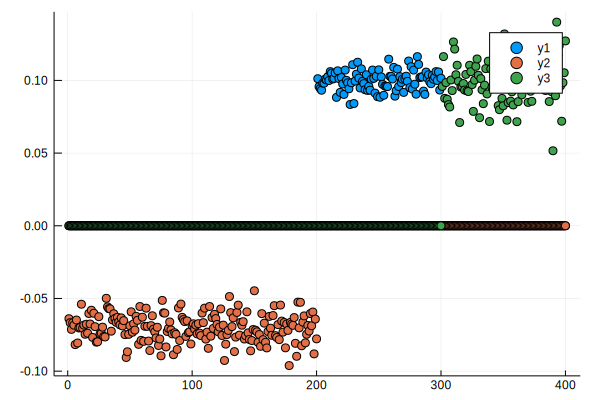

In [22]:
# Plot the first three left singular vectors
k=size(B,1)
x=collect(1:k)
scatter(x,S.U[:,1])
scatter!(x,S.U[:,2])
scatter!(x,S.U[:,3])

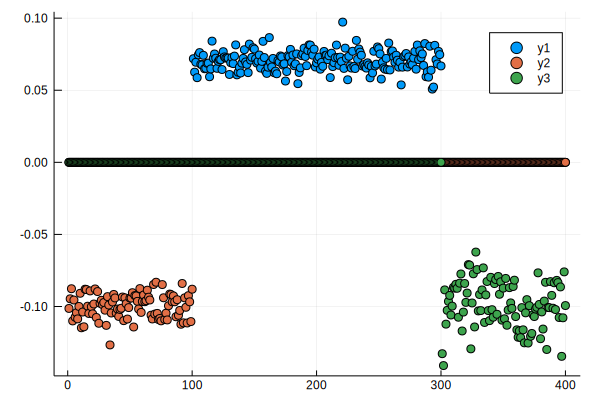

In [24]:
# Plot the first three right singular vectors
scatter(x,S.Vt[1,:])
scatter!(x,S.Vt[2,:])
scatter!(x,S.Vt[3,:])

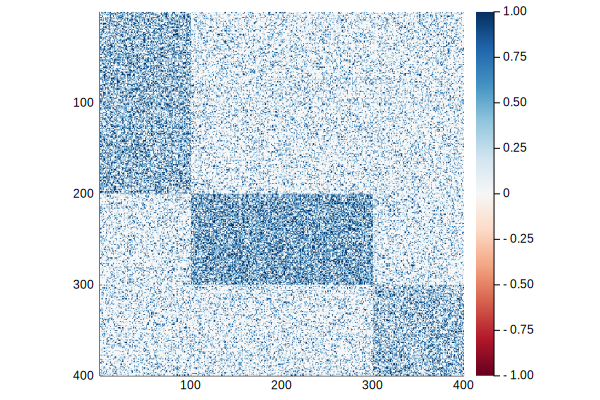

In [25]:
# Add random noise
noise=sprand(k,k,0.3)
C=B+noise
spy(Matrix(C))

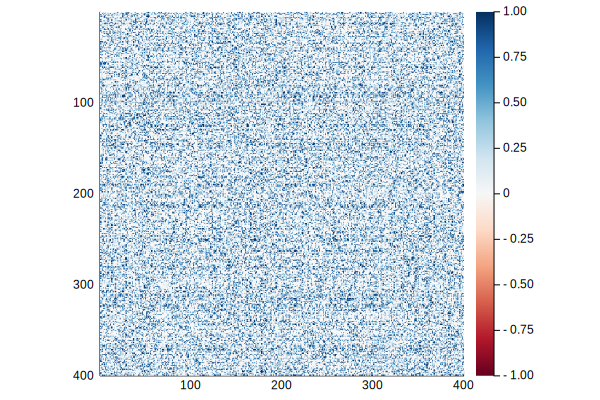

In [26]:
# Apply random permutation to rows and columns of C
using Random
D=C[randperm(k),randperm(k)]
spy(Matrix(D))

__Question.__ Given D, can we recover C?

__Answer.__ Yes (with spectral partitioning)!

In [27]:
S,rest=svds(D,nsv=3)

(SVD{Float64,Float64,Array{Float64,2}}([-0.0333642 0.0111307 0.0827229; -0.072974 -0.0572434 -0.0253028; … ; -0.0459207 0.0592952 -0.0421229; -0.0730361 -0.075499 -0.0098331], [99.5311, 42.4603, 25.8021], [-0.0513387 -0.0402481 … -0.0566415 -0.0502894; 0.0761654 0.0326739 … 0.0631841 -0.0394411; -0.0245445 0.102595 … -0.0526352 -0.00649382]), 3, 1, 20, [1.94724, 0.214787, 2.66943, 0.717233, 1.05205, -0.0234921, 2.54433, 0.836593, 2.51233, 0.371605  …  1.76811, 0.81999, 0.243691, -3.58657, 0.189828, -2.97767, -0.176745, -0.168131, 4.59056, 2.22565])

In [28]:
# K-means on rows of U 
outU=kmeans(Matrix(transpose(S.U)),3)

KmeansResult{Float64}([-0.0379643 -0.0689002 -0.0433807; 0.014952 -0.0693447 0.048351; 0.0879257 -0.0167569 -0.0250707], [1, 2, 3, 1, 3, 2, 3, 3, 3, 3  …  3, 1, 2, 2, 3, 3, 1, 3, 3, 2], [6.28331e-5, 0.000236069, 0.000333658, 0.000244708, 0.00136708, 0.000130579, 7.01368e-5, 0.000448973, 0.00010242, 7.22468e-5  …  0.00021142, 0.00011638, 8.89534e-5, 0.000142848, 0.00153771, 0.0006669, 0.000115343, 5.18644e-5, 0.000417002, 0.00010292], [100, 100, 200], [100.0, 100.0, 200.0], 0.10709990047358411, 2, true)

In [29]:
# K-means on Vt
outV=kmeans(S.Vt,3)

KmeansResult{Float64}([-0.0541846 -0.0518067 -0.0374366; -0.0430985 0.0739828 0.0228354; -0.0106543 -0.0396177 0.0860935], [2, 3, 1, 1, 1, 3, 1, 1, 2, 1  …  1, 1, 3, 1, 3, 2, 3, 1, 2, 1], [0.000232185, 0.000376989, 0.000206553, 0.000483368, 6.04833e-5, 8.53957e-5, 5.09619e-5, 0.000112475, 0.000317248, 0.000856565  …  0.000474114, 8.49192e-6, 0.000186029, 0.000787827, 0.000253779, 0.000170709, 4.03648e-5, 0.000541099, 0.000309441, 4.58584e-5], [200, 100, 100], [200.0, 100.0, 100.0], 0.11240805126422213, 2, true)

In [30]:
sortperm(outV.assignments)

400-element Array{Int64,1}:
   3
   4
   5
   7
   8
  10
  12
  14
  15
  17
  20
  23
  25
   ⋮
 344
 350
 366
 367
 369
 370
 372
 374
 381
 393
 395
 397

In [ ]:
E=D[sortperm(outU.assignments),sortperm(outV.assignments)]
spy(Matrix(E))